In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Read and clean data
estate_df = pd.read_csv('/Users/karol/Downloads/Machine Learning/Real Estate Project/Housing_Prices_24.csv')
pd.set_option("display.max_columns", None)

# Drop non-numeric columns and ID
estate_num = estate_df.drop(columns=["Id","LotConfig", "BldgType", 'YearBuilt', "Foundation", 'CentralAir', "KitchenQual", 'PavedDrive'])
estate_num

,SalePrice,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YearRemodAdd,YrSold
0,208500,8450,856,856,854,2,1,3,8,0,2,0,61,0,0,0,0,2003,2008
1,181500,9600,1262,1262,0,2,0,3,6,1,2,298,0,0,0,0,0,1976,2007
2,223500,11250,920,920,866,2,1,3,6,1,2,0,42,0,0,0,0,2002,2008
3,140000,9550,756,961,756,1,0,3,7,1,3,0,35,272,0,0,0,1970,2006
4,250000,14260,1145,1145,1053,2,1,4,9,1,3,192,84,0,0,0,0,2000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,7917,953,953,694,2,1,3,7,1,2,0,40,0,0,0,0,2000,2007
1456,210000,13175,1542,2073,0,2,0,3,7,2,2,349,0,0,0,0,0,1988,2010
1457,266500,9042,1152,1188,1152,2,0,4,9,2,1,0,60,0,0,0,0,2006,2010
1458,142125,9717,1078,1078,0,1,0,2,5,0,1,366,0,112,0,0,0,1996,2010


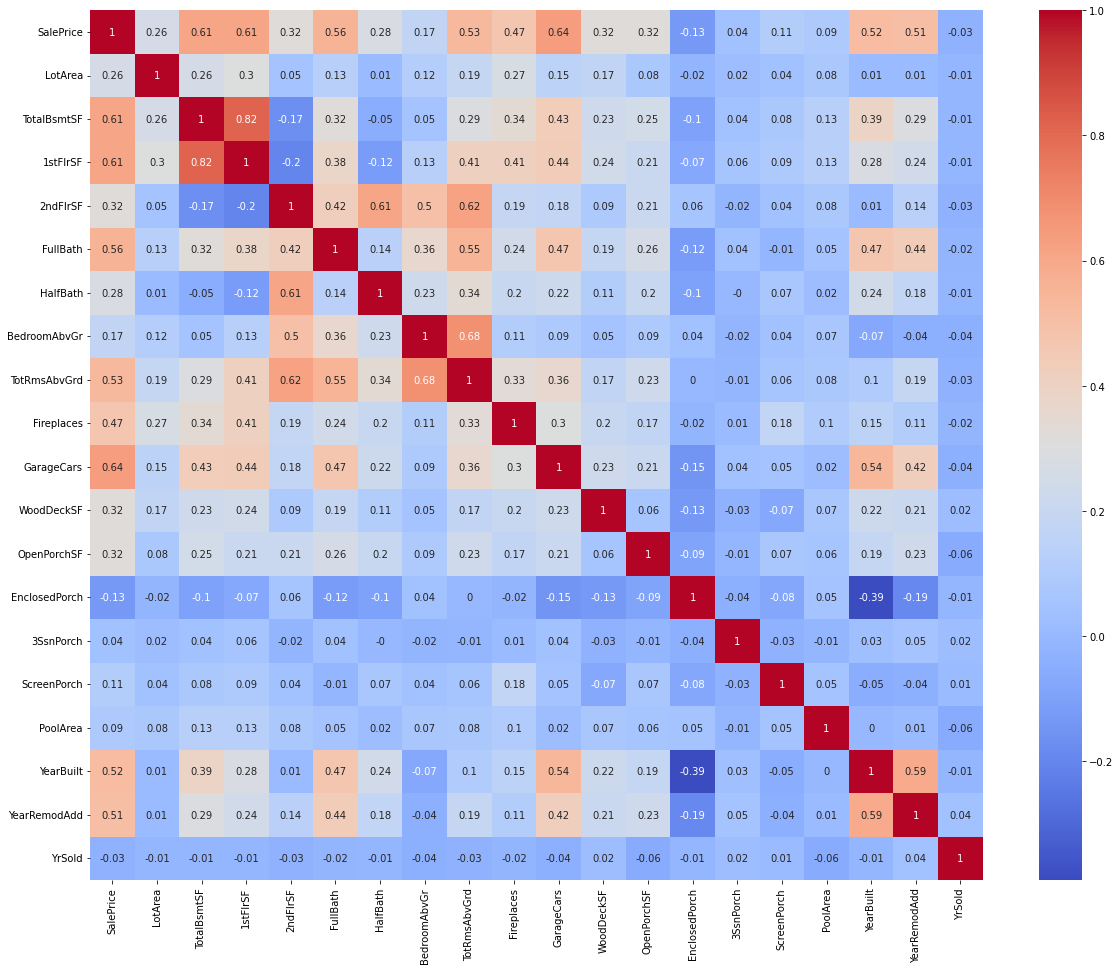

In [8]:
# Compute correlations
cormat = estate_df.drop(columns=['Id']).corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (20,16))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

In [9]:
# Fit full regression
pd.reset_option('max_columns')
X = estate_num.drop(columns=['SalePrice'])
y = estate_df['SalePrice']
X = sm.add_constant(X)
fullreg = sm.OLS(y, X).fit()

# Display regression summary
print(fullreg.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     232.2
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:41:34   Log-Likelihood:                -17550.
No. Observations:                1460   AIC:                         3.514e+04
Df Residuals:                    1441   BIC:                         3.524e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           1.82e+05   1.61e+06      0.113

In [10]:
# Calculate variance inflation factors (VIF) for full model
vifres = pd.DataFrame()
vifres["Variable"] = X.columns
vifres["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifres)

         Variable           VIF
0           const  2.314679e+06
1         LotArea  1.164804e+00
2     TotalBsmtSF  3.308998e+00
3        1stFlrSF  5.465551e+00
4        2ndFlrSF  4.551087e+00
5        FullBath  2.220537e+00
6        HalfBath  1.884751e+00
7    BedroomAbvGr  2.129352e+00
8    TotRmsAbvGrd  4.295805e+00
9      Fireplaces  1.454552e+00
10     GarageCars  1.680194e+00
11     WoodDeckSF  1.167212e+00
12    OpenPorchSF  1.190563e+00
13  EnclosedPorch  1.126165e+00
14      3SsnPorch  1.013894e+00
15    ScreenPorch  1.081042e+00
16       PoolArea  1.060888e+00
17   YearRemodAdd  1.524620e+00
18         YrSold  1.014339e+00


In [11]:
# Create function for automated Forward / Backward model selection
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.01,
                       threshold_out = 0.05,
                       verbose=True):
    """ Perform a forward-backward feature selection
    based on p-value from statsmodels.api.OLS

    Arguments:
        X - pandas.DataFrame of numeric features
        y - vector, series of the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions

    Returns: list of selected features

    Example Call: stepwise_selection(X, y)
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval:.4f}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.4f}')
        if not changed:
           break
    return included


In [12]:
# Automated variable selection
selected_features  = stepwise_selection(X, y)
print('resulting features:')
print(selected_features)

<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  const with p-value 0.0000
Add  GarageCars with p-value 0.0000


<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  TotalBsmtSF with p-value 0.0000
Add  2ndFlrSF with p-value 0.0000


<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  YearRemodAdd with p-value 0.0000


<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  1stFlrSF with p-value 0.0000
Add  Fireplaces with p-value 0.0000


<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  BedroomAbvGr with p-value 0.0000
Add  WoodDeckSF with p-value 0.0000


<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  ScreenPorch with p-value 0.0062
resulting features:
['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch']


<ipython-input-11-b4fd7d9acffe>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [13]:
# Fit stepwise regression
X = estate_num[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch']]
X = sm.add_constant(X)
stepreg = sm.OLS(y, X).fit()

# Display regression summary
print(stepreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     455.7
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:41:37   Log-Likelihood:                -17564.
No. Observations:                1460   AIC:                         3.515e+04
Df Residuals:                    1450   BIC:                         3.520e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.477e+06   1.17e+05    -12.624   

In [14]:
#Calculate Variance Inflation Factors (VIF)
vifresstep = pd.DataFrame()
vifresstep["Variable"] = X.columns
vifresstep["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vifresstep)

       Variable           VIF
0         const  12047.376294
1    GarageCars      1.572651
2   TotalBsmtSF      3.200581
3      2ndFlrSF      1.950798
4  YearRemodAdd      1.321677
5      1stFlrSF      3.812750
6    Fireplaces      1.412797
7  BedroomAbvGr      1.574903
8    WoodDeckSF      1.130797
9   ScreenPorch      1.055861


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


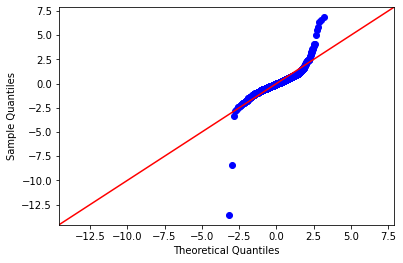

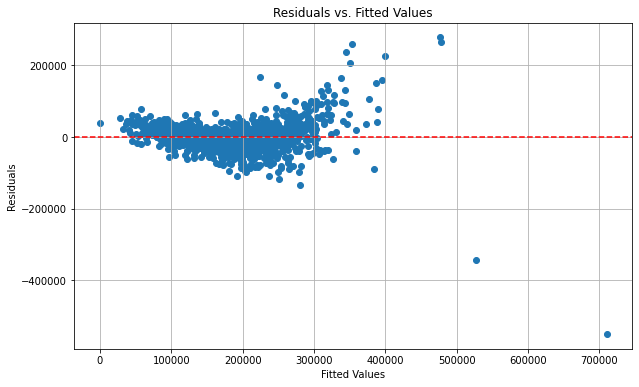

In [15]:
# Calculate residuals
residuals = stepreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals,fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(stepreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [16]:
# Log transformed regression
X = estate_num[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch']]
X = sm.add_constant(X)
logy = np.log(y)
logreg = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     582.9
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:41:38   Log-Likelihood:                 385.51
No. Observations:                1460   AIC:                            -751.0
Df Residuals:                    1450   BIC:                            -698.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.7559      0.536      1.411   

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


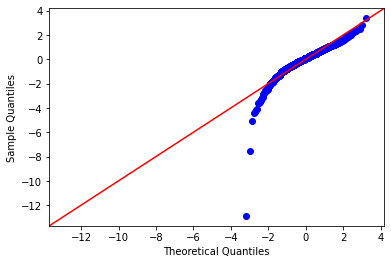

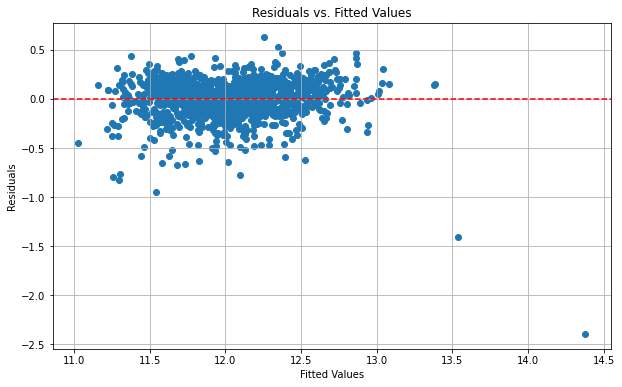

In [17]:
# Calculate residuals
residuals = logreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [18]:
# Square Root transformed regression
X = estate_num[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch']]
X = sm.add_constant(X)
sqrty = np.sqrt(y)
sqrtreg = sm.OLS(sqrty, X).fit()

# Display regression summary
print(sqrtreg.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     574.7
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:41:39   Log-Likelihood:                -7461.8
No. Observations:                1460   AIC:                         1.494e+04
Df Residuals:                    1450   BIC:                         1.500e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1727.9410    115.647    -14.942   

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


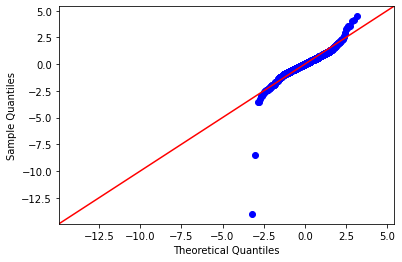

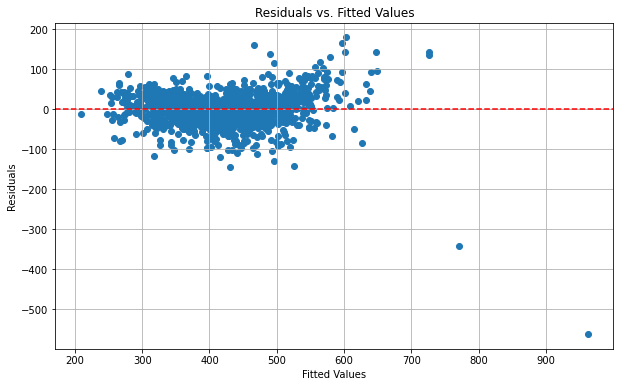

In [19]:
# Calculate residuals
residuals = sqrtreg.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(sqrtreg.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [20]:
# Log transformed regression including categorical variables
X = estate_df[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'BedroomAbvGr', 'WoodDeckSF', 'ScreenPorch', 
                "LotConfig", "BldgType", "Foundation", 'CentralAir', "KitchenQual", 'PavedDrive']]
X = pd.get_dummies(X, columns=["LotConfig", "BldgType", "Foundation", 'CentralAir', "KitchenQual", 'PavedDrive'], drop_first=True, dtype='float')
X = sm.add_constant(X)
logy = np.log(y)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     240.8
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:41:39   Log-Likelihood:                 540.65
No. Observations:                1460   AIC:                            -1023.
Df Residuals:                    1431   BIC:                            -870.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.6807      0.61

In [21]:
# Log transformed regression including categorical variables
X = estate_df[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'WoodDeckSF', 'ScreenPorch', 
                'CentralAir', "KitchenQual", 'PavedDrive']]
X = pd.get_dummies(X, columns=[ 'CentralAir', "KitchenQual", 'PavedDrive'], drop_first=True, dtype='float')
X = sm.add_constant(X)
logy = np.log(y)
logreg2 = sm.OLS(logy, X).fit()

# Display regression summary
print(logreg2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     448.4
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        16:41:39   Log-Likelihood:                 492.15
No. Observations:                1460   AIC:                            -954.3
Df Residuals:                    1445   BIC:                            -875.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.6234      0.604      7.

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


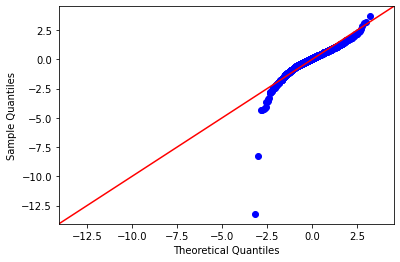

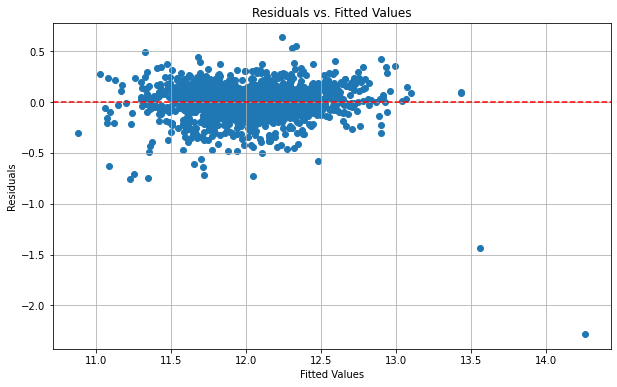

In [22]:
# Calculate residuals
residuals = logreg2.resid

# Generate Q-Q Plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()


# Residuals vs. Fitted
plt.figure(figsize=(10, 6))
plt.scatter(logreg2.fittedvalues, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.grid(True)
plt.show()

In [23]:
# Load new data

data_path = '/Users/karol/Downloads/Machine Learning/Real Estate Project/homesforsale.csv'
new_dat = pd.read_csv(data_path)

# Create X-matrix for regression (e.g., add / delete / modify any variables that were added / deleted / modified when creating the model)

Xnew = new_dat[['GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd', '1stFlrSF', 'Fireplaces', 'WoodDeckSF', 'ScreenPorch', 
                'CentralAir', 'KitchenQual', 'PavedDrive']]
Xnew = pd.get_dummies(Xnew, columns=[ 'CentralAir', 'KitchenQual', 'PavedDrive'], drop_first=True, dtype='float')
Xnew = sm.add_constant(Xnew)


# Create a list of expected columns (from training set)
expected_columns = ['const', 'GarageCars', 'TotalBsmtSF', '2ndFlrSF', 'YearRemodAdd',
       '1stFlrSF', 'Fireplaces', 'WoodDeckSF', 'ScreenPorch', 'CentralAir_Y',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'PavedDrive_P',
       'PavedDrive_Y']

# Add missing columns
for col in expected_columns:
    if col not in Xnew.columns:
        Xnew[col] = 0

# Ensure columns are in the correct order
Xnew = Xnew[expected_columns]


# Make predictions (in log scale)
log_predictions = logreg2.predict(Xnew)

# Reverse log transformation to get actual house prices
predictions = np.exp(log_predictions)

# Print the actual predicted house prices
print(predictions)



0    111064.519306
1    124622.473140
2    155497.629329
3    262600.986931
4     88266.261545
dtype: float64


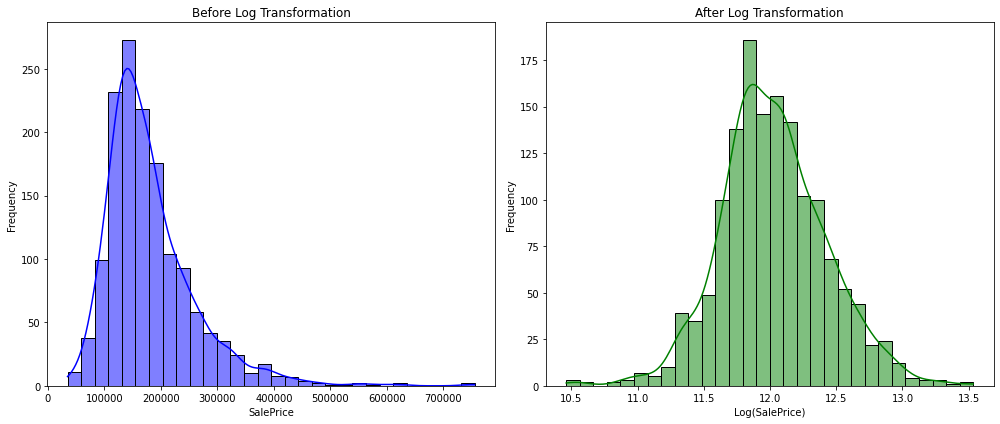

In [24]:
# Before log transformation
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # Create subplots: 1 row, 2 columns, 1st plot
sns.histplot(estate_df['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Before Log Transformation')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Apply log transformation
estate_df['Log_SalePrice'] = np.log(estate_df['SalePrice'])

# After log transformation
plt.subplot(1, 2, 2)  # Create subplots: 1 row, 2 columns, 2nd plot
sns.histplot(estate_df['Log_SalePrice'], kde=True, bins=30, color='green')
plt.title('After Log Transformation')
plt.xlabel('Log(SalePrice)')
plt.ylabel('Frequency')

# Display the plots
plt.tight_layout()
plt.show()
